<a href="https://colab.research.google.com/github/JohnNun/pneumonia_identification_project/blob/main/pneumonia_identification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Identification Project

# Business and Data Understanding


# Data preparation

In [1]:
# For Google Colab only
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install scikeras[tensorflow]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00


In [2]:
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [3]:
# Following code taken from stackoverflow user fdsig
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"" ,
'key':""}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [4]:
# Downloading and Importing images
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [5]:
# Linking directory path
train_data_dir = 'chest_xray/train'
val_data_dir = 'chest_xray/val'

In [6]:
# Getting train and validation data from directory
val_generator = ImageDataGenerator().flow_from_directory(val_data_dir, target_size=(64, 64), batch_size=16, seed=42)
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=1304, seed=42)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [7]:
# Creating datasets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)

In [8]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(val_images))
print(np.shape(val_labels))

(1304, 64, 64, 3)
(1304, 2)
(16, 64, 64, 3)
(16, 2)


In [9]:
# Reshaping data
train_img_unrow = train_images.reshape(1304, -1)
val_img_unrow = val_images.reshape(16, -1)

In [10]:
print(np.shape(train_img_unrow))
print(np.shape(val_img_unrow))

(1304, 12288)
(16, 12288)


In [11]:
# Normalizing data
train_img_final = train_img_unrow/255.0
val_img_final = val_img_unrow/255.0

In [12]:
# Scaling data
train_scaled_data = (train_img_unrow/255.0) * 2 - 1
val_scaled_data = (val_img_unrow/255.0) * 2 - 1

# Modeling

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Rescaling
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
# Function to quickly plot model results
def plot_results(model_results):
    """
    This function will take in the results of a model and plot the loss and accuracy of the model.

    Args:
    model_results (list): the results of the model in [] brackets.
    """
    for results in model_results:
        train_loss = results.history['loss']
        train_acc = results.history['accuracy']
        val_loss = results.history['val_loss']
        val_acc = results.history['val_accuracy']

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
        sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

        sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
        sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
        ax1.set_title('Loss')
        ax2.set_title('Accuracy')
        ax1.legend();

In [15]:
model_1 = Sequential()

In [16]:
model_1.add(layers.Input(shape=(12288,)))
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(2, activation='softmax'))

In [17]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_1_results = model_1.fit(train_img_final, train_labels, epochs=10, batch_size=125, validation_data=(val_img_final, val_labels))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.5953 - loss: 1.0039 - val_accuracy: 0.5000 - val_loss: 0.7652
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7331 - loss: 0.5135 - val_accuracy: 0.5625 - val_loss: 0.7504
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8202 - loss: 0.3838 - val_accuracy: 0.5625 - val_loss: 0.7576
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8418 - loss: 0.3580 - val_accuracy: 0.7500 - val_loss: 0.5190
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8902 - loss: 0.2953 - val_accuracy: 0.6875 - val_loss: 0.8075
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8800 - loss: 0.2691 - val_accuracy: 0.7500 - val_loss: 0.4734
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9183 - loss: 0.2382 - val_accuracy: 0.6875 - val_loss: 0.6697
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9085 - loss: 0.2320 - val_accuracy: 0.8750 - val_lo

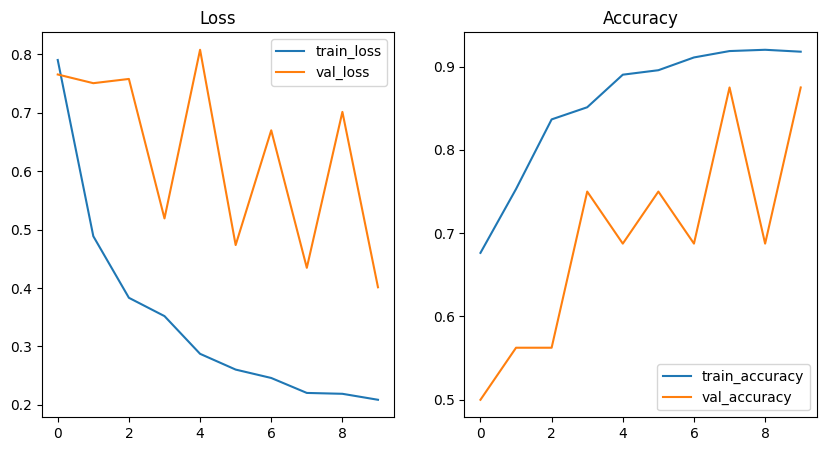

In [19]:
plot_results([model_1_results])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=5e-6)

In [20]:
model_2 = Sequential()

In [21]:
model_2.add(layers.Input(shape=(12288,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(25, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(2, activation='softmax'))

In [22]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_2_results = model_2.fit(train_img_final, train_labels, epochs=50, batch_size=500, validation_data=(val_img_final, val_labels))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4361 - loss: 0.9960 - val_accuracy: 0.5000 - val_loss: 0.8745
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6392 - loss: 0.8147 - val_accuracy: 0.5000 - val_loss: 0.8313
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6791 - loss: 0.7524 - val_accuracy: 0.5000 - val_loss: 0.8041
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6733 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss: 0.7394
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6963 - loss: 0.7098 - val_accuracy: 0.5000 - val_loss: 0.6859
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6576 - loss: 0.6610 - val_accuracy: 0.5000 - val_loss: 0.7193
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7007 - loss: 0.6394 - val_accuracy: 0.5000 - val_loss: 0.7526
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6904 - loss: 0.6286 - val_accuracy: 0.5000 - val_loss: 0.7253
Ep

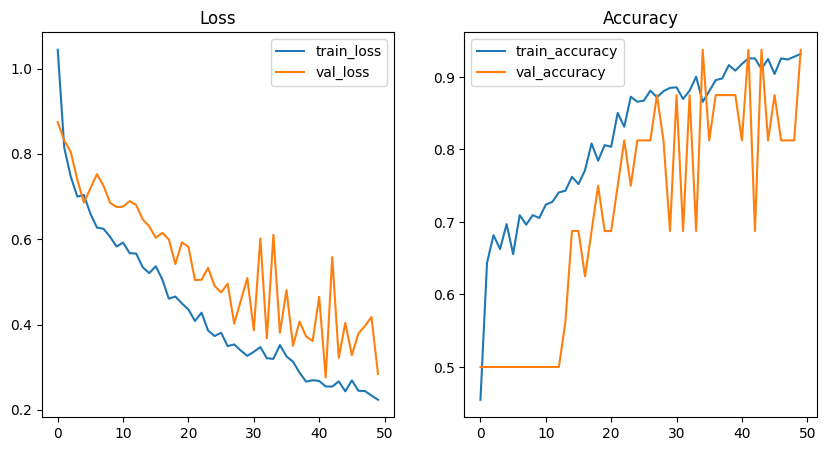

In [24]:
plot_results([model_2_results])

In [25]:
model_3 = Sequential()

In [26]:
model_3.add(layers.Input(shape=(12288,)))
model_3.add(Dense(50, activation='relu'))
model_3.add(Dense(50, activation='relu', kernel_regularizer=l2))
model_3.add(Dropout(0.5))
model_3.add(Dense(25, activation='relu'))
model_3.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='relu'))
model_3.add(Dense(2, activation='softmax'))

In [27]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
model_3_results = model_3.fit(train_img_final, train_labels, epochs=100, batch_size=500, validation_data=(val_img_final, val_labels), callbacks=[early_stop])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3801 - loss: 7.5682 - val_accuracy: 0.5000 - val_loss: 7.3852
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5284 - loss: 7.3078 - val_accuracy: 0.5000 - val_loss: 7.2020
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5479 - loss: 7.0656 - val_accuracy: 0.5000 - val_loss: 6.9916
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6078 - loss: 6.8486 - val_accuracy: 0.5000 - val_loss: 6.7615
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6388 - loss: 6.6361 - val_accuracy: 0.5000 - val_loss: 6.6520
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6981 - loss: 6.4442 - val_accuracy: 0.5000 - val_loss: 6.4160
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6913 - loss: 6.2881 - val_accuracy: 0.5000 - val_loss: 6.3193
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7170 - loss: 6.1192 - val_accuracy: 0.5000 - val_loss: 6

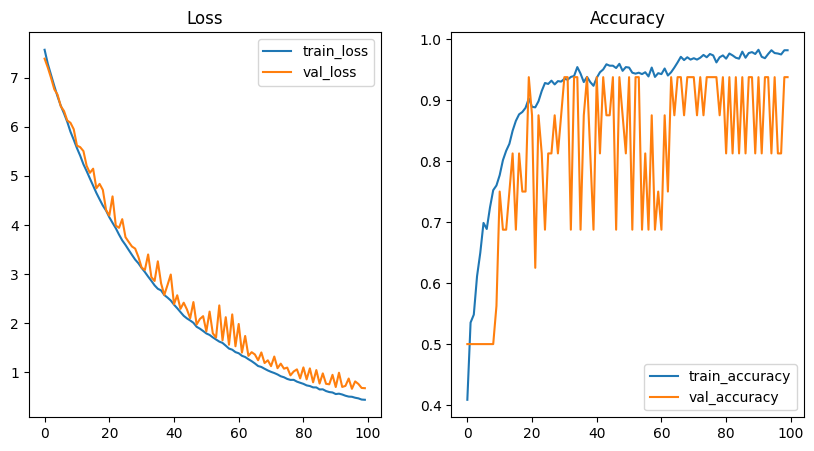

In [30]:
plot_results([model_3_results])

In [36]:
model_4 = Sequential()

In [37]:
model_4.add(layers.Input(shape=(12288,)))
model_4.add(Dense(75, activation='relu'))
model_4.add(Dense(50, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(50, activation='relu', kernel_regularizer=l2(l2=0.5)))
model_4.add(Dense(25, activation='relu'))
model_4.add(Dropout(0.25))
model_4.add(Dense(25, activation='relu', kernel_regularizer=l2(l2=0.25)))
model_4.add(Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model_4.add(Dense(2, activation='softmax'))

In [38]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model_4_results = model_4.fit(train_img_final, train_labels, epochs=60, batch_size=250, validation_data=(val_img_final, val_labels), callbacks=[early_stop])

Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 554ms/step - accuracy: 0.5406 - loss: 31.3536 - val_accuracy: 0.5625 - val_loss: 29.6938
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6454 - loss: 29.2082 - val_accuracy: 0.5000 - val_loss: 27.7685
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7197 - loss: 27.1747 - val_accuracy: 0.5000 - val_loss: 25.8766
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7184 - loss: 25.2940 - val_accuracy: 0.5000 - val_loss: 24.0808
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7293 - loss: 23.5160 - val_accuracy: 0.5000 - val_loss: 22.3772
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7375 - loss: 21.8463 - val_accuracy: 0.5000 - val_loss: 20.8188
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7348 - loss: 20.2885 - val_accuracy: 0.5000 - val_loss: 19.3412
Epoch 8/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7526 - loss: 18.8666 - val_accuracy: 0.5000 - v

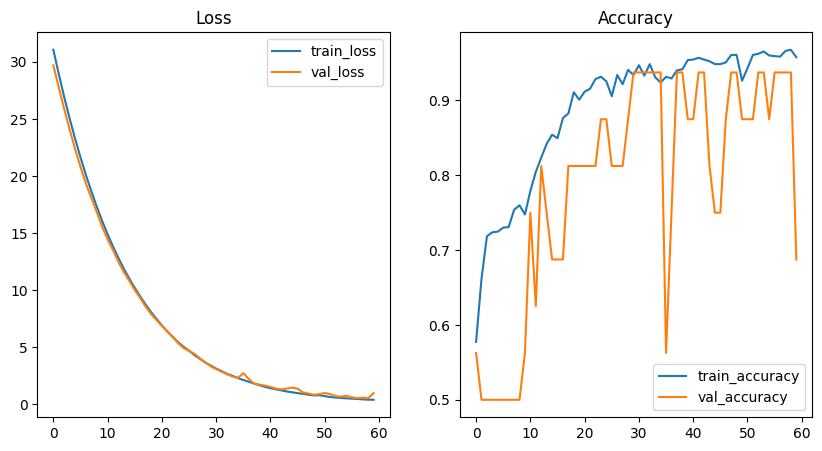

In [40]:
plot_results([model_4_results])

In [ ]:
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.BatchNormalization())

model_5.add(layers.Dense(32, activation='relu'))
model_5.add(layers.BatchNormalization())

model_5.add(layers.Dense(50, activation='relu'))
model_5.add(layers.BatchNormalization())

In [152]:
model_5 = models.Sequential()

In [153]:
model_5.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dropout(0.1))
model_5.add(layers.MaxPooling2D())

model_5.add(layers.Flatten())
model_5.add(layers.Dense(2, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [154]:
model_5.compile(Adam(learning_rate=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [155]:
model_5_results = model_5.fit(train_images, train_labels, epochs=25, batch_size=310, validation_data=(val_images, val_labels), callbacks=[early_stop])

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4933 - loss: 1.2961 - val_accuracy: 0.5000 - val_loss: 1.5918
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6141 - loss: 1.0015 - val_accuracy: 0.5000 - val_loss: 1.2656
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6569 - loss: 0.8444 - val_accuracy: 0.5000 - val_loss: 1.1189
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7174 - loss: 0.7561 - val_accuracy: 0.5000 - val_loss: 1.0333
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7603 - loss: 0.6541 - val_accuracy: 0.5000 - val_loss: 0.9828
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7740 - loss: 0.6085 - val_accuracy: 0.5000 - val_loss: 0.9460
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7795 - loss: 0.5509 - val_accuracy: 0.5000 - val_loss: 0.9152
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7610 - loss: 0.6051 - val_accuracy: 0.5000 - val_loss: 0.8872
E

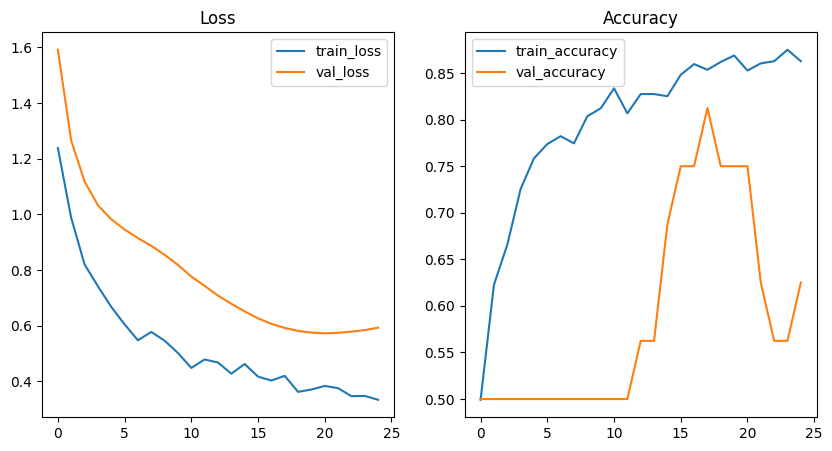

In [156]:
plot_results([model_5_results])

In [ ]:
data_augmentation = Sequential([layers.RandomFlip('horizontal_and_vertical'),
                                layers.RandomRotation(0.5),
                                layers.RandomZoom(0.2)])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
model_6 = keras.Sequential([
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(2, activation='softmax')
    ])

In [ ]:
model_6.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_6_results = model_6.fit(train_images, train_labels, epochs=100, batch_size=250, validation_data=(val_images, val_labels), callbacks=[early_stop])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.4407 - loss: 1.2731 - val_accuracy: 0.5000 - val_loss: 2.8930
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4847 - loss: 1.1681 - val_accuracy: 0.5000 - val_loss: 2.2766
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5464 - loss: 1.0310 - val_accuracy: 0.5000 - val_loss: 1.9788
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6350 - loss: 0.8988 - val_accuracy: 0.5000 - val_loss: 1.7827
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6664 - loss: 0.8609 - val_accuracy: 0.5000 - val_loss: 1.6436
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7087 - loss: 0.7818 - val_accuracy: 0.5000 - val_loss: 1.5422
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7228 - loss: 0.7066 - val_accuracy: 0.5000 - val_loss: 1.4674
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7191 - loss: 0.7391 - val_accuracy: 0.5000 - val_loss

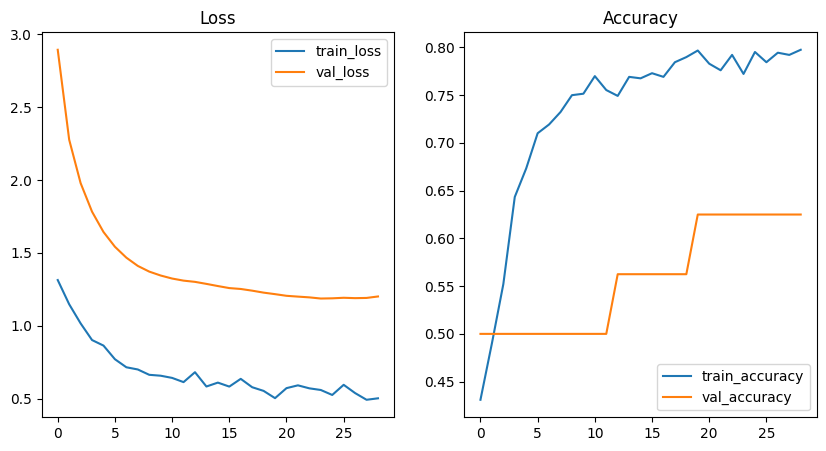

In [ ]:
plot_results([model_6_results])

# Evaluation